In [109]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [110]:
resolution = 1000

energy_gap_df = pd.read_csv(f"energy_gap_over_V_resolution={resolution}.csv")
energy_gap_df = energy_gap_df.to_numpy()

image_mu_V_ratios = np.linspace(0,3,resolution)
image_J_V_ratios = np.linspace(-3,3,resolution)

mu_V_ratio_grid, J_V_ratio_grid = np.meshgrid(image_mu_V_ratios, image_J_V_ratios)

In [124]:
def construct_full_hamitlonian_tilde(N, M, V, mu_V_ratio, J_V_ratio):
    
    mu = mu_V_ratio * abs(V)
    J = J_V_ratio * abs(V)
    
    dim = M**N
    H = np.zeros((dim, dim), dtype=np.complex128)

    # precompute powers of M for faster state-to-index conversion
    M_powers = np.array([M**i for i in range(N)])

    # helper function to convert state index to state representation
    def index_to_state(index):
        return np.array([(index // M_powers[i]) % M for i in range(N-1, -1, -1)])
    
    def state_to_index(state):
        return np.dot(state, M_powers[::-1])

    # apply the chemical potential term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            if state[j] == 0:  
                H[alpha, alpha] -= mu
    
    # apply the tunneling term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            for n in range(1, M):
                if state[j] == n:
                    new_state = state.copy()
                    new_state[j] = n - 1
                    beta = state_to_index(new_state)
                    H[alpha, beta] -= J
                    H[beta, alpha] -= J  

    # apply the interaction term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for i in range(N - 1):
            j = i + 1
            for n in range(1, M):
                if state[i] == n and state[j] == n - 1:
                    new_state = state.copy()
                    new_state[i], new_state[j] = n - 1, n
                    beta = state_to_index(new_state)
                    H[alpha, beta] += V
                    H[beta, alpha] += V  
                    
    # rescale H to H tilde by dividing by |V|
    H_tilde = H/abs(V)
    
    return H_tilde

In [189]:
def placeholder_func(N, M, V, mu_V_ratio_routine, J_V_ratio_routine, times, dt = 0.1, initial_state = None):
    
    n_excited_states = M**N

    initial_hamiltonian = construct_full_hamitlonian_tilde(N, M, V, mu_V_ratio_routine[0], J_V_ratio_routine[0])
    
    if np.all(initial_state) == None:
        _, eigenvectors_0 = exact_diagonalize(initial_hamiltonian)
        psi_0 = eigenvectors_0[0]
    else: 
        psi_0 = initial_state

    adiabatic_wavefunctions = []
    true_energies = []
    adiabatic_energies = []
    adiabatic_overlaps = []
    adiabatic_probabilities = []

    psi = psi_0.copy()

    for index, t in enumerate(times):
        instantaneous_hamiltonian = construct_full_hamitlonian_tilde(N, M, V, mu_V_ratio_routine[index], J_V_ratio_routine[index])
        
        eigenvalues, eigenvectors = exact_diagonalize(instantaneous_hamiltonian)
        true_energies.append(eigenvalues)
        
        psi = evolve_wavefunction(psi, instantaneous_hamiltonian, dt)
        psi = psi / np.linalg.norm(psi)
        
        adiabatic_wavefunctions.append(psi)
        
        adiabatic_energy = np.real(np.conj(psi).T @ instantaneous_hamiltonian @ psi)
        adiabatic_energies.append(adiabatic_energy)
        
        overlap = [np.dot(np.conj(eigenvectors[i]).T, psi) for i in range(n_excited_states)] 
        probability = [np.abs(np.conj(eigenvectors[i]).T @ psi)**2 for i in range(n_excited_states)]
               
        adiabatic_probabilities.append(probability)
        adiabatic_overlaps.append(overlap)

    true_energies = np.array(true_energies)
    adiabatic_overlaps = np.array(adiabatic_overlaps)

    adiabatic_diff = adiabatic_energies - true_energies[:, 0]
    adiabatic_diff = np.array(adiabatic_diff)
    
    energy_gaps = [eigenvalues - eigenvalues[0] for eigenvalues in true_energies]
    
    true_energies = np.array(true_energies)
    energy_gaps = np.array(energy_gaps)
    adiabatic_probabilities = np.array(adiabatic_probabilities)
    adiabatic_overlaps = np.array(adiabatic_overlaps)
        
    return adiabatic_energies, adiabatic_diff, adiabatic_wavefunctions, adiabatic_probabilities, adiabatic_overlaps, true_energies, energy_gaps

In [201]:
dt = 0.01
T = 10

times = np.linspace(0,T,int(T/dt))
J_V_ratios = np.linspace(3, 3, int(T/dt))
mu_V_ratios = np.linspace(0,0, int(T/dt))

initial_state = [1,0,0,0]

adiabatic_energies, adiabatic_diff, adiabatic_wavefunctions, adiabatic_probabilities, adiabatic_overlaps, true_energies, energy_gaps = \
    placeholder_func(N=2,M=2, V=-1,J_V_ratio_routine=J_V_ratios,mu_V_ratio_routine=mu_V_ratios, times = times, dt = dt, initial_state = initial_state)

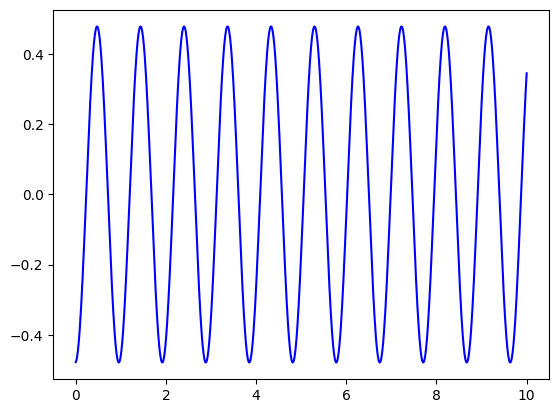

In [203]:
fig, ax = plt.subplots()

ax.plot(times, np.real(adiabatic_overlaps[:,0]), "b")
#ax.plot(times, np.imag(adiabatic_overlaps[:,0]), "r")

In [106]:
N = 2
M = 5
V = -1

init_J_V_ratio = 0.1
init_mu_V_ratio = 2.9

mid_1_J_V_ratio = 2.9
mid_1_mu_V_ratio = 2.9

mid_2_J_V_ratio = 2.9
mid_2_mu_V_ratio = 0

final_J_V_ratio = 0.5
final_mu_V_ratio = 0

T1 = 0.1
T2 = 0.1+T1
T3 = 0.1+T2

dt = 0.01

times_1 = np.linspace(0, T1, int(T1/dt)) 
times_2 = np.linspace(T1, T2, int((T2-T1)/dt))
times_3 = np.linspace(T2, T3, int((T3-T2)/dt))

J_V_ratio_routine_1 = []
mu_V_ratio_routine_1 = []

J_V_ratio_routine_2 = []
mu_V_ratio_routine_2 = []

J_V_ratio_routine_3 = []
mu_V_ratio_routine_3 = []

for t in times_1:
    
    #J_V_ratio_routine.append(np.tan(np.arctan(initial_J_V_ratio) + (np.arctan(final_J_V_ratio)-np.arctan(initial_J_V_ratio))*t/T))
    #mu_V_ratio_routine.append(np.tan(np.arctan(initial_mu_V_ratio) + (np.arctan(final_mu_V_ratio)-np.arctan(initial_mu_V_ratio))*t/T)) 
    
    J_V_ratio_routine_1.append(init_J_V_ratio*(1-t/T1) + (t/T1)*mid_1_J_V_ratio)
    mu_V_ratio_routine_1.append(init_mu_V_ratio*(1-t/T1) + (t/T1)*mid_1_mu_V_ratio)
    
for t in times_2:
    
    J_V_ratio_routine_2.append(mid_1_J_V_ratio*(1-(t-T1)/(T2-T1)) + ((t-T1)/(T2-T1))*mid_2_J_V_ratio)
    mu_V_ratio_routine_2.append(mid_1_mu_V_ratio*(1-(t-T1)/(T2-T1)) + ((t-T1)/(T2-T1))*mid_2_mu_V_ratio)
    
for t in times_3:
     
    J_V_ratio_routine_3.append(mid_2_J_V_ratio*(1-(t-T2)/(T3-T2)) + ((t-T2)/(T3-T2))*final_J_V_ratio)
    mu_V_ratio_routine_3.append(mid_2_mu_V_ratio*(1-(t-T2)/(T3-T2)) + ((t-T2)/(T3-T2))*final_mu_V_ratio)
    
adiabatic_energies_1, adiabatic_diff_1, adiabatic_wavefunctions_1, adiabatic_overlaps_1, true_energies_1, energy_gaps_1 =  \
    placeholder_func(N, M, V, mu_V_ratio_routine_1, J_V_ratio_routine_1, times_1, initial_state = None)
    
adiabatic_energies_2, adiabatic_diff_2, adiabatic_wavefunctions_2, adiabatic_overlaps_2, true_energies_2, energy_gaps_2 =  \
    placeholder_func(N, M, V, mu_V_ratio_routine_2, J_V_ratio_routine_2, times_2, initial_state = adiabatic_wavefunctions_1[-1])

adiabatic_energies_3, adiabatic_diff_3, adiabatic_wavefunctions_3, adiabatic_overlaps_3, true_energies_3, energy_gaps_3 =  \
    placeholder_func(N, M, V, mu_V_ratio_routine_3, J_V_ratio_routine_3, times_3, initial_state = adiabatic_wavefunctions_2[-1])    
    

Text(0.5, 0, 'Time [$t$]')

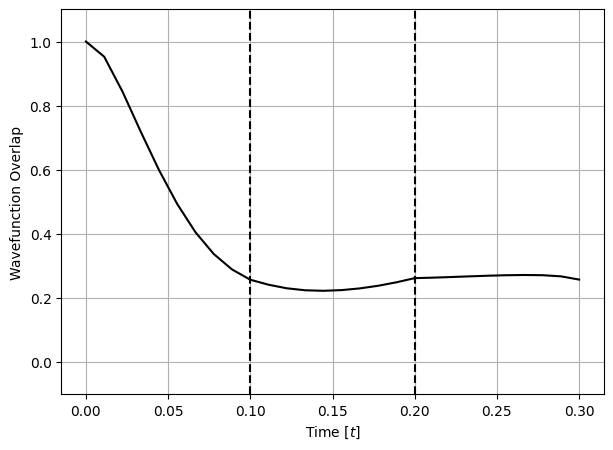

In [107]:
fig, ax = plt.subplots(figsize = (7,5))

for i in range(len(adiabatic_overlaps_1)):
    
    if i == 0:
        
        ax.plot(times_1, adiabatic_overlaps_1[:,i], color = 'k')

        ax.plot(times_2, adiabatic_overlaps_2[:,i], color = 'k')

        ax.plot(times_3, adiabatic_overlaps_3[:,i], color = 'k')
    
ax.set_ylim(-0.1,1.1)

ax.axvline(T1, linestyle = "--", color = "k")
ax.axvline(T2, linestyle = "--", color = "k")
ax.grid()

ax.set_ylabel("Wavefunction Overlap")
ax.set_xlabel("Time [$t$]")

In [108]:
plt.figure(figsize=(7,5))

plt.pcolormesh(J_V_ratio_grid, mu_V_ratio_grid, energy_gap_df, shading = "auto", cmap = "plasma")

plt.plot(J_V_ratio_routine_1, mu_V_ratio_routine_1, ".r")
plt.plot(J_V_ratio_routine_2, mu_V_ratio_routine_2, ".g")
plt.plot(J_V_ratio_routine_3, mu_V_ratio_routine_3, ".b")

plt.colorbar(label = "$\Delta E/V$")
plt.ylabel("$\mu/V$")
plt.xlabel("$J/V$")


Text(0.5, 0, '$J/V$')

Error in callback <function flush_figures at 0x00000270C5A8AD30> (for post_execute):


KeyboardInterrupt: 